In this notebook we perform the different classification tasks to determine which one is the best.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

random_seed = 50

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=12)
plt.rc('axes', titlesize=18, labelsize=15)

# Metrics for Performance Evaluation

In [84]:
class Performance_metrics():

    def __init__(self, y_actual, y_predicted, ctp=0, ctn=0, cfp=1, cfn=5):

        self.y_actual = y_actual # df of actual class labels
        self.y_predicted = y_predicted # df of predicted class labels

        self.df_confusion = pd.crosstab(self.y_actual, self.y_predicted)
        self.tp = self.df_confusion[1][1]
        self.tn = self.df_confusion[0][0]
        self.fp = self.df_confusion[0][1]
        self.fn = self.df_confusion[1][0]

        self.ctp = ctp
        self.ctn = ctn
        self.cfp = cfp
        self.cfn = cfn
        

    def cost_matrix(self):

        """Cost of classifying instances of class j as class i.
        """

        cost_matrix = np.array([[self.ctn, self.cfp], [self.cfn, self.ctp]])
        return cost_matrix
    
    def accuracy(self):

        """Accuracy of the model.
        """
        accuracy = (self.tp + self.tn) / (self.tp + self.tn + self.fp + self.fn)
        return accuracy
    
    def cost(self):

        """Cost of the model.
        """
        cost_matrix = np.array([[self.ctn, self.cfp], [self.cfn, self.ctp]])

        cost = (self.tp * self.ctp) + (self.tn * self.ctn) + (self.fp * self.cfp) + (self.fn * self.cfn)
        return cost
    
    def precision(self):
            
        """Precision of the model.
        """
        precision = self.tp / (self.tp + self.fp)
        return precision
    
    def recall(self):
        
        """Recall of the model.
        """
        recall = self.tp / (self.tp + self.fn)
        return recall
    
    def f_measure(self):
    
        """F-measure of the model.
        """

        f_measure = 2*self.tp / (2*self.tp + self.fp + self.fn)
        return f_measure
    

In [4]:
# Import data
df = pd.read_csv("Preprocessed data/normalized_data.csv", index_col=0)

dFeat_df = df.drop(columns = ["readmitted"])
dClass_df = df["readmitted"]

dFeat = dFeat_df.to_numpy()
dClass = dClass_df.to_numpy()

print(dFeat.shape)
print(dClass.shape)

(4837, 30)
(4837,)


# Feature Selection

## Wrapper method

In this work we are going to use Wrapper methods since they provide a balance between embedded aproaches (which depends on the algorithm) and filter approaches (which rely on statistical measures). First, we measure the variation in accuracy after removing each feature, for simplicity, we only consider random forest.

## Mean decrease in impurity

Another metric in RF classifier is the MDI (Mean Decrease impurity) which counts the number of times a feature is used to a split a node weighted by the number of samples it splits. [cite web]

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

Text(0, 0.5, 'Mean decrease in impurity')

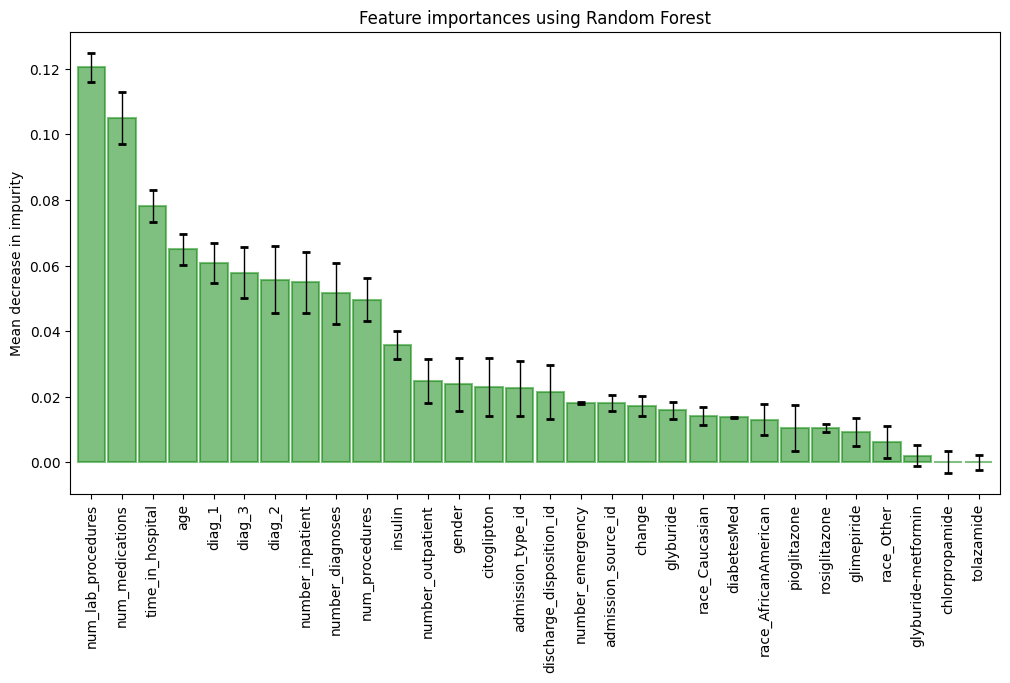

In [8]:


forest = RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion='entropy')
forest.fit(dFeat, dClass)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

forest_importances = pd.DataFrame(importances, index=dFeat_df.columns, columns=["Importance"])
forest_importances = forest_importances.sort_values(by="Importance", ascending=False)

forest_importances.plot.bar(yerr=std, legend=False, figsize=(12, 6), color='green', alpha=0.5, edgecolor='green', capsize=5, error_kw=dict(lw=1, capsize=3, capthick=2), width=0.9, lw=1.5)
plt.title("Feature importances using Random Forest") 
plt.xticks(rotation=90)
plt.ylabel("Mean decrease in impurity")

Be careful, it considers that the labels are true (?)

## Feature Permutation

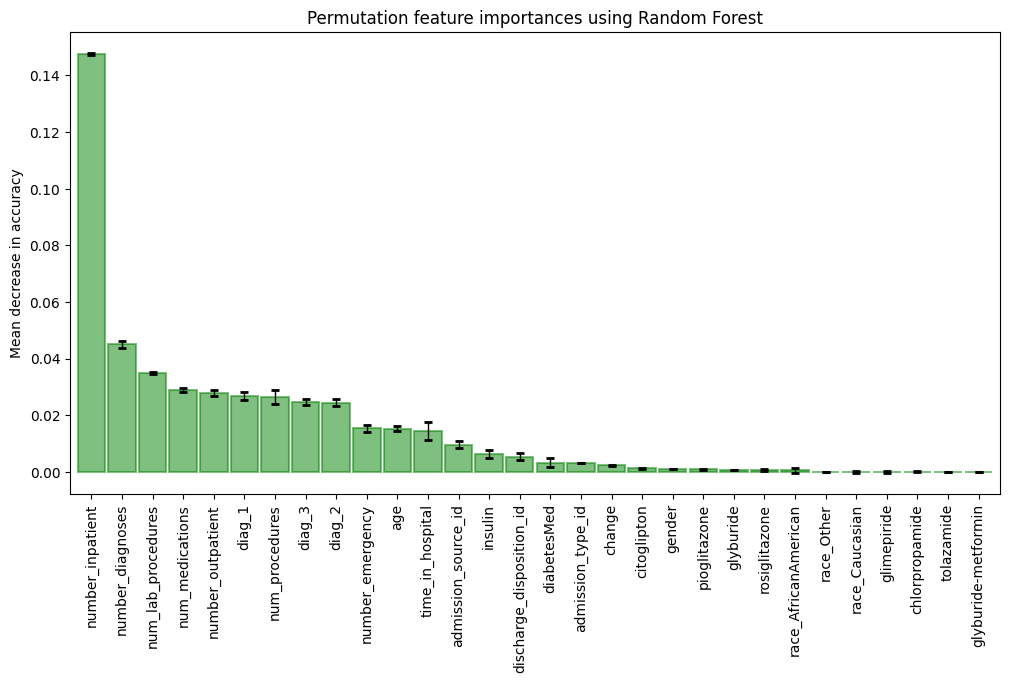

In [9]:
from sklearn.inspection import permutation_importance

result = permutation_importance(forest, dFeat, dClass, n_repeats=10, random_state=random_seed, n_jobs=-1)
forest_permutations = pd.DataFrame(result.importances_mean, index=dFeat_df.columns, columns=["Permutation Importance"])
forest_permutations = forest_permutations.sort_values(by="Permutation Importance", ascending=False)

forest_permutations.plot.bar(yerr=result.importances_std, legend=False, figsize=(12, 6), color='green', alpha=0.5, edgecolor='green', capsize=5, error_kw=dict(lw=1, capsize=3, capthick=2), width=0.9, lw=1.5)
plt.title("Permutation feature importances using Random Forest")
plt.xticks(rotation=90)
plt.ylabel("Mean decrease in accuracy")
plt.show()

In [10]:
forest_permutations

,Permutation Importance
number_inpatient,0.147591
number_diagnoses,0.044987
num_lab_procedures,0.034960
num_medications,0.028944
number_outpatient,0.027724
diag_1,0.026876
num_procedures,0.026339
diag_3,0.024602
diag_2,0.024437
number_emergency,0.015402


We can analyze the impact of deleting features starting from the least important in terms of MDA.

In [11]:
forest_permutations_asc = forest_permutations.sort_values(by="Permutation Importance", ascending=True)
accuracy_list = []

acc_full_features = []
error_list = []

kf = KFold(n_splits=10, shuffle=True, random_state=42)
dFeat_df1 = dFeat_df.copy()

for i in range(dFeat.shape[1]):

    column = forest_permutations_asc.index[:i]

    dFeat1 = dFeat_df1.drop(columns=column)
    dFeat1 = dFeat1.to_numpy()
    accuracy_mean = []

    for train_index, test_index in kf.split(dFeat1, dClass):

        X_train, X_test = dFeat1[train_index], dFeat1[test_index]
        y_train, y_test = dClass[train_index], dClass[test_index]

        # Create a Random Forest Classifier
        rf = RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion='entropy')

        # Fit the model on the training data
        rf.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = rf.predict(X_test)

        # Calculate performance metrics
        pm = Performance_metrics(y_test, y_pred)
        accuracy_mean.append(pm.accuracy())
    
    acc = np.mean(accuracy_mean)
    print("Accuracy without ", column, ": ", acc)
    accuracy_list.append(acc)
    error_list.append(np.std(accuracy_mean)/np.sqrt(len(accuracy_mean)))

Accuracy without  Index([], dtype='object') :  0.6309814691237616
Accuracy without  Index(['glyburide-metformin'], dtype='object') :  0.6349100833290556
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide'], dtype='object') :  0.6336682750714371
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide', 'tolazamide'], dtype='object') :  0.6326365005218759
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide', 'tolazamide', 'glimepiride'], dtype='object') :  0.6353233064695515
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide', 'tolazamide', 'glimepiride',
       'race_Caucasian'],
      dtype='object') :  0.6322185719418921
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide', 'tolazamide', 'glimepiride',
       'race_Caucasian', 'race_Other'],
      dtype='object') :  0.6285034135824649
Accuracy without  Index(['glyburide-metformin', 'chlorpropamide', 'tolazamide', 'glimepiride',
       'race_Caucasian', 'race_Other', 'race_Afric

Text(0, 0.5, 'Accuracy')

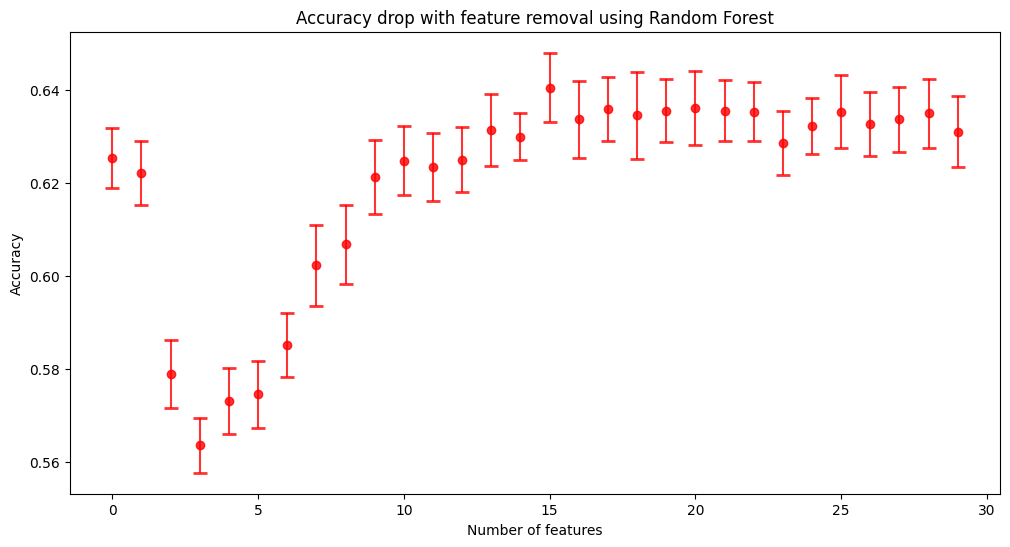

In [ ]:
plt.figure(figsize=(12, 6))
plt.errorbar(range(len(forest_permutations_asc))[::-1],accuracy_list, yerr=error_list, fmt='o-', color='red', alpha=0.8, capsize=5, capthick=2, lw=1.5)
plt.title("Accuracy drop with feature removal using Random Forest")
plt.xlabel("Number of features")
plt.ylabel("Accuracy")

In [13]:
features_str = forest_permutations_asc.index.to_list()
features_str[:10]

['glyburide-metformin',
 'chlorpropamide',
 'tolazamide',
 'glimepiride',
 'race_Caucasian',
 'race_Other',
 'race_AfricanAmerican',
 'rosiglitazone',
 'glyburide',
 'pioglitazone']

In [14]:
# Delete the follwoing features according to the analysis above
# dFeat_df = dFeat_df.drop(columns=["race_Other", "race_Caucasian", "race_AfricanAmerican", "glyburide-metformin", "glimepiride", "pioglitazone", "rosiglitazone", "tolazamide", "chlorpropamide", "citoglipton", "glyburide"])
dFeat_df = dFeat_df.drop(columns=features_str[:10])
dFeat = dFeat_df.to_numpy()
dFeat.shape

(4837, 20)

# Cross-Validation

In this section we study how the accuracy variation is reflected in the number of $k$ groups for cross-validation. For simplicity we just consider random forest.

In [68]:
n_splits_list = [2, 5, 7, 9, 10, 15, 20, 25, 30, 50, 100]
accuracy_list = []
error_list = []

for n_splits in n_splits_list:

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

    accuracy_mean = []

    for train_index, test_index in kf.split(dFeat, dClass):

        X_train, X_test = dFeat[train_index], dFeat[test_index]
        y_train, y_test = dClass[train_index], dClass[test_index]

        # Create a Random Forest Classifier
        rf = RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion='entropy')

        # Fit the model on the training data
        rf.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = rf.predict(X_test)

        # Calculate performance metrics
        pm = Performance_metrics(y_test, y_pred)
        accuracy_mean.append(pm.accuracy())

    acc = np.mean(accuracy_mean)
    print("Accuracy with ", n_splits, " folds: ", acc)
    accuracy_list.append(acc)
    error_list.append(np.std(accuracy_mean)/np.sqrt(len(accuracy_mean)))

Accuracy with  2  folds:  0.6243521699421898
Accuracy with  5  folds:  0.6295189604040783
Accuracy with  7  folds:  0.6367583212735166
Accuracy with  9  folds:  0.6361296292450371
Accuracy with  10  folds:  0.6355282069708947
Accuracy with  15  folds:  0.6282688819234789
Accuracy with  20  folds:  0.6330509927643084
Accuracy with  25  folds:  0.6342738101597137
Accuracy with  30  folds:  0.6373616542698668
Accuracy with  50  folds:  0.6343041237113403
Accuracy with  100  folds:  0.6317091836734694


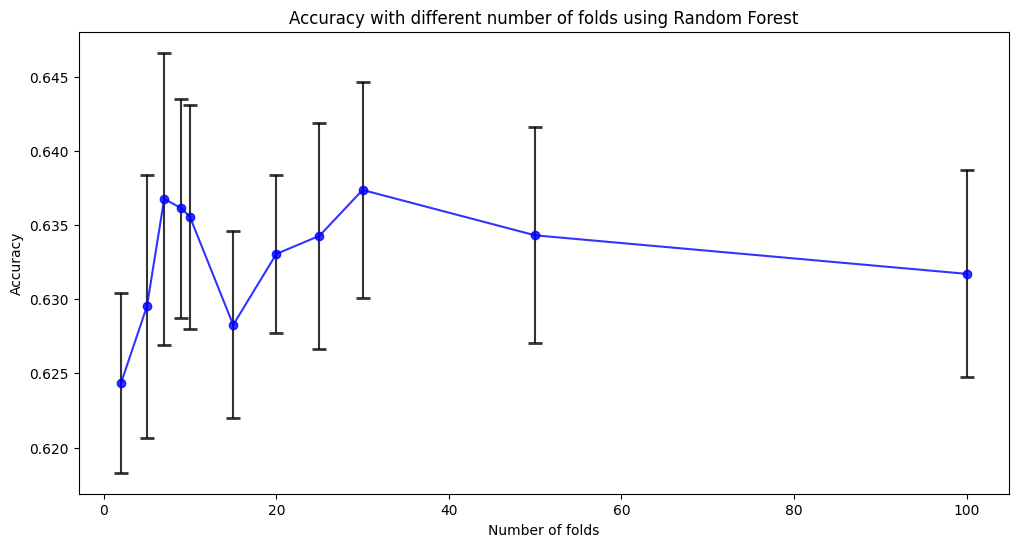

In [69]:
# Plot the accuracy with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(n_splits_list, accuracy_list, yerr=error_list, fmt='o-', color='blue', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black')
plt.title("Accuracy with different number of folds using Random Forest")
plt.xlabel("Number of folds")
plt.ylabel("Accuracy")
plt.show()

# Model Parameters

## Random Forest

Parameter to be considered: n_estimators (number of trees in the forest)

In [16]:
n_estimators_list = [5, 10, 25, 50, 100, 200, 300, 400, 500]
criterion_list = ['gini', 'entropy', 'log_loss']

accuracy_array = np.zeros((len(criterion_list), len(n_estimators_list)))
error_array = np.zeros((len(criterion_list), len(n_estimators_list)))

kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

for i, criterion in enumerate(criterion_list):

    for j, n_estimators in enumerate(n_estimators_list):

        accuracy_mean = []

        for train_index, test_index in kf.split(dFeat, dClass):

            X_train, X_test = dFeat[train_index], dFeat[test_index]
            y_train, y_test = dClass[train_index], dClass[test_index]

            # Create a Random Forest Classifier
            rf = RandomForestClassifier(n_estimators=n_estimators, random_state=random_seed, criterion=criterion)

            # Fit the model on the training data
            rf.fit(X_train, y_train)

            # Make predictions on the test data
            y_pred = rf.predict(X_test)

            # Calculate performance metrics
            pm = Performance_metrics(y_test, y_pred)
            accuracy_mean.append(pm.accuracy())
        
        acc = np.mean(accuracy_mean)
        print("Accuracy with ", n_estimators, " estimators: ", acc)
        accuracy_array[i, j] = acc
        error_array[i, j] = np.std(accuracy_mean)/np.sqrt(len(accuracy_mean))

Accuracy with  5  estimators:  0.5751531406669746
Accuracy with  10  estimators:  0.6026551511729377
Accuracy with  25  estimators:  0.6193923994319251
Accuracy with  50  estimators:  0.6311726810738667
Accuracy with  100  estimators:  0.636139914104341
Accuracy with  200  estimators:  0.6359345858357716
Accuracy with  300  estimators:  0.6369676436870113
Accuracy with  400  estimators:  0.6334539636911178
Accuracy with  500  estimators:  0.6365595537532297
Accuracy with  5  estimators:  0.5927262460859299
Accuracy with  10  estimators:  0.6086456034084492
Accuracy with  25  estimators:  0.6225001283301679
Accuracy with  50  estimators:  0.6320123881388702
Accuracy with  100  estimators:  0.6355282069708947
Accuracy with  200  estimators:  0.6382205738925106
Accuracy with  300  estimators:  0.6338748866416852
Accuracy with  400  estimators:  0.6336682750714371
Accuracy with  500  estimators:  0.6349070889584725
Accuracy with  5  estimators:  0.5927262460859299
Accuracy with  10  estima

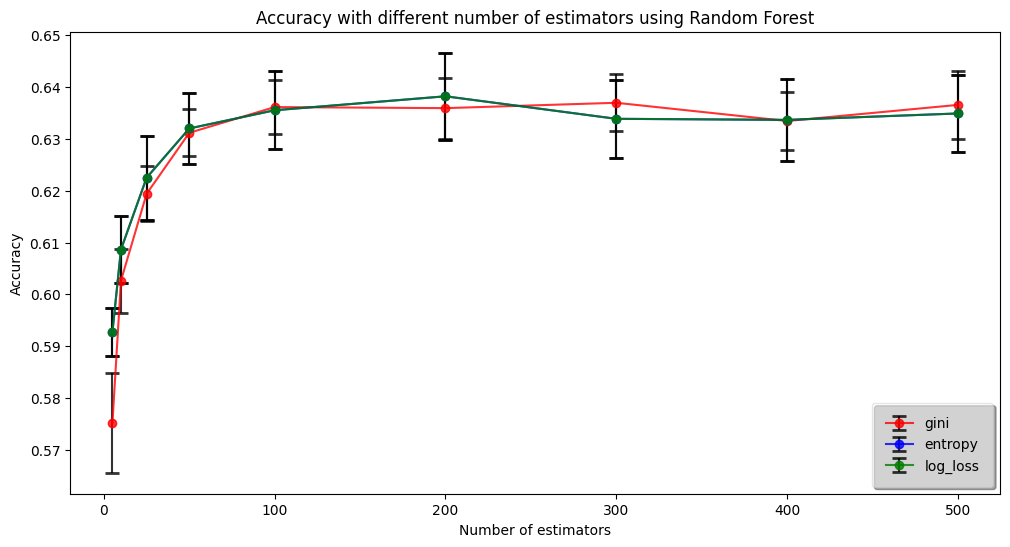

In [ ]:
# Plot the accuracy with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(n_estimators_list, accuracy_array[0], yerr=error_array[0], fmt='o-', color='red', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=criterion_list[0])
plt.errorbar(n_estimators_list, accuracy_array[1], yerr=error_array[1], fmt='o-', color='blue', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=criterion_list[1])
plt.errorbar(n_estimators_list, accuracy_array[2], yerr=error_array[2], fmt='o-', color='green', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=criterion_list[2])
plt.title("Accuracy with different number of estimators using Random Forest")
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.legend(fancybox=True, loc='best', fontsize=10, shadow=True, borderpad=1)
plt.show()

The, we select n_estimators = 100.

## Decision Tree

For the DecisionTreeClassifier we study the variation of max_depth parameter (maximum depth of the tree).

In [ ]:
from sklearn.tree import DecisionTreeClassifier

criterion_list = ['gini', 'entropy', 'log_loss']
max_depth_list = [1,2,3,4,5,6,7,8,9,10,13,18,22,25,35, 50]

accuracy_array = np.zeros((len(criterion_list), len(max_depth_list)))
error_array = np.zeros((len(criterion_list), len(max_depth_list)))

kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

for i, criterion in enumerate(criterion_list):

    print("Criterion: ", criterion)

    for j, max_depth in enumerate(max_depth_list):

        accuracy_mean = []

        for train_index, test_index in kf.split(dFeat, dClass):

            X_train, X_test = dFeat[train_index], dFeat[test_index]
            y_train, y_test = dClass[train_index], dClass[test_index]

            # Create Classifier
            dt = DecisionTreeClassifier(max_depth=max_depth, random_state=random_seed, criterion=criterion)

            # Fit the model on the training data
            dt.fit(X_train, y_train)

            # Make predictions on the test data
            y_pred = dt.predict(X_test)

            # Calculate performance metrics
            pm = Performance_metrics(y_test, y_pred)
            accuracy_mean.append(pm.accuracy())
        
        acc = np.mean(accuracy_mean)
        print("Accuracy with ", max_depth, " as max_depth: ", acc)
        accuracy_array[i][j] = acc
        error_array[i][j] = np.std(accuracy_mean)/np.sqrt(len(accuracy_mean))

Criterion:  gini
Accuracy with  1  estimators:  0.6255958797460774
Accuracy with  2  estimators:  0.6280756463562788
Accuracy with  3  estimators:  0.6253909792447342
Accuracy with  4  estimators:  0.6208463802337321
Accuracy with  5  estimators:  0.6224979894940368
Accuracy with  6  estimators:  0.6173309891689338
Accuracy with  7  estimators:  0.6270442995739438
Accuracy with  8  estimators:  0.6280782129596358
Accuracy with  9  estimators:  0.6241474599182109
Accuracy with  10  estimators:  0.6084368530020703
Accuracy with  13  estimators:  0.5960298923737659
Accuracy with  18  estimators:  0.5623338124326267
Accuracy with  22  estimators:  0.5635777595263761
Accuracy with  25  estimators:  0.5617169720924662
Accuracy with  35  estimators:  0.5598553291241037
Accuracy with  50  estimators:  0.5598553291241037
Criterion:  entropy
Accuracy with  1  estimators:  0.6255958797460774
Accuracy with  2  estimators:  0.6280756463562788
Accuracy with  3  estimators:  0.6258029190835515
Accura

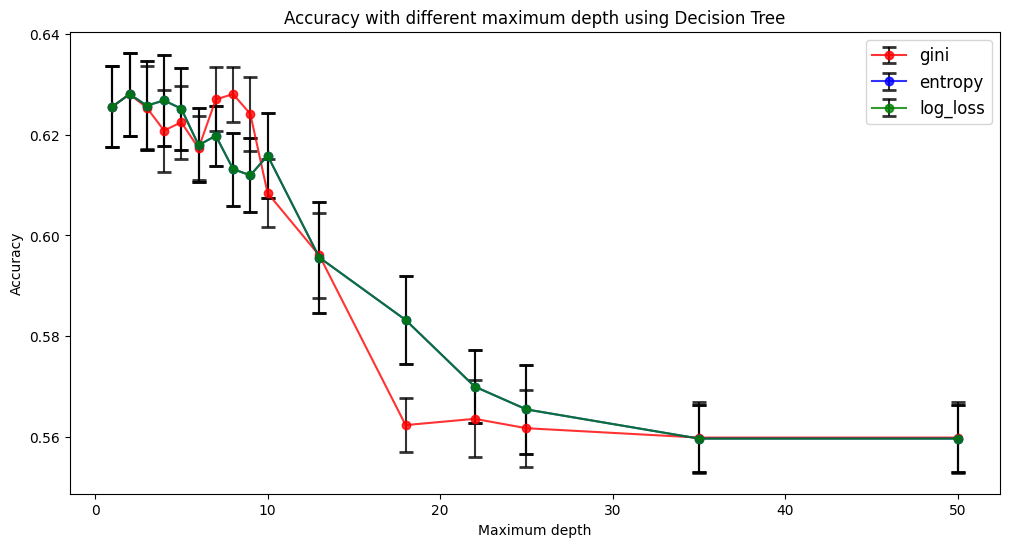

In [20]:
# Plot the accuracy with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(max_depth_list, accuracy_array[0], yerr=error_array[0], fmt='o-', color='red', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=criterion_list[0])
plt.errorbar(max_depth_list, accuracy_array[1], yerr=error_array[1], fmt='o-', color='blue', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=criterion_list[1])
plt.errorbar(max_depth_list, accuracy_array[2], yerr=error_array[2], fmt='o-', color='green', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=criterion_list[2])
plt.title("Accuracy with different maximum depth using Decision Tree")
plt.xlabel("Maximum depth")
plt.ylabel("Accuracy")
plt.legend(fancybox=True, loc='best', fontsize=12)

## K-nearest Neighbors

In this classifier we consider how the accuracy varies depending on the number of neighbors (n_neighbors)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors_list = [5, 10, 25, 50, 75, 90, 100, 110, 125, 150, 200, 250 ,300, 400, 500]
accuracy_list = []
error_list = []

kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

for n_neighbors in n_neighbors_list:

    accuracy_mean = []

    for train_index, test_index in kf.split(dFeat, dClass):

        X_train, X_test = dFeat[train_index], dFeat[test_index]
        y_train, y_test = dClass[train_index], dClass[test_index]

        # Create Classifier
        kn = KNeighborsClassifier(n_neighbors=n_neighbors, n_jobs=-1)

        # Fit the model on the training data
        kn.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = kn.predict(X_test)

        # Calculate performance metrics
        pm = Performance_metrics(y_test, y_pred)
        accuracy_mean.append(pm.accuracy())
    
    acc = np.mean(accuracy_mean)
    print("Accuracy with ", n_neighbors, " neighbors: ", acc)
    accuracy_list.append(acc)
    error_list.append(np.std(accuracy_mean)/np.sqrt(len(accuracy_mean)))

Accuracy with  5  estimators:  0.5410164604828637
Accuracy with  10  estimators:  0.5511609602518692
Accuracy with  25  estimators:  0.5577823691460055
Accuracy with  50  estimators:  0.5679140358982255
Accuracy with  75  estimators:  0.5675016682921822
Accuracy with  90  estimators:  0.5679178858032612
Accuracy with  100  estimators:  0.5621301952329621
Accuracy with  110  estimators:  0.5621263453279263
Accuracy with  125  estimators:  0.5571668121075235
Accuracy with  150  estimators:  0.5615142104272539
Accuracy with  200  estimators:  0.5608935201820577
Accuracy with  250  estimators:  0.5623419400099242
Accuracy with  300  estimators:  0.5577939188611126
Accuracy with  400  estimators:  0.5569661892784422
Accuracy with  500  estimators:  0.5586229317454613


Text(0, 0.5, 'Accuracy')

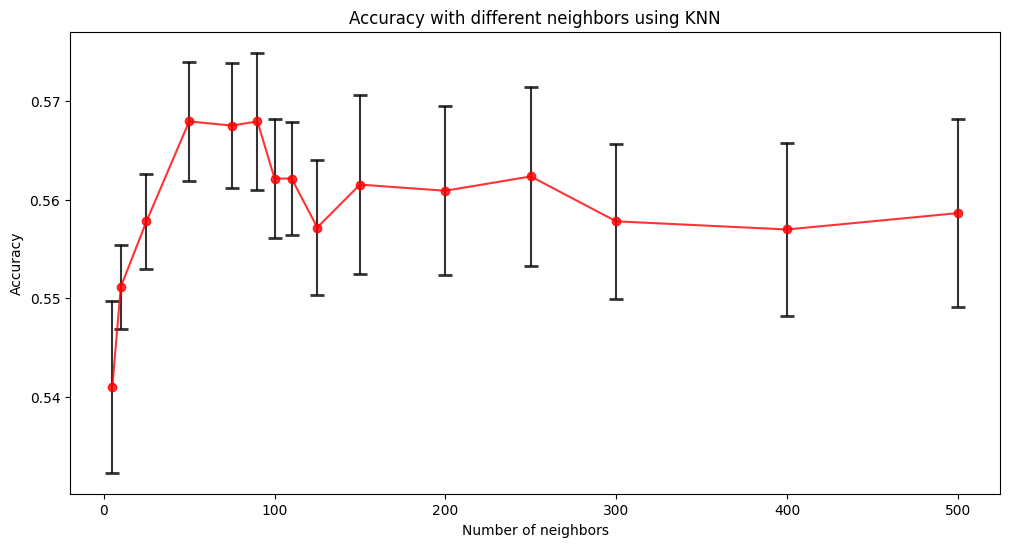

In [22]:
# Plot the accuracy with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(n_neighbors_list, accuracy_list, yerr=error_list, fmt='o-', color='red', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5)
plt.title("Accuracy with different neighbors using KNN")
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")

## Gaussian Naive Bayes

In [23]:
from sklearn.naive_bayes import GaussianNB

No analysis performed in this model.

## Support Vector Machine

Now, we study the effect of the regularization parameter for different kernels.

In [44]:
from sklearn.svm import SVC

kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']
C_list = [0.01, 0.05, 0.1, 0.5, 1, 2, 5]

accuracy_array = np.zeros((len(kernel_list), len(C_list)))
error_array = np.zeros((len(kernel_list), len(C_list)))

kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

for i, kernel in enumerate(kernel_list):

    print("Kernel: ", kernel)

    for j, C in enumerate(C_list):

        accuracy_mean = []

        for train_index, test_index in kf.split(dFeat, dClass):

            X_train, X_test = dFeat[train_index], dFeat[test_index]
            y_train, y_test = dClass[train_index], dClass[test_index]

            # Create Classifier
            svc = SVC(kernel=kernel, C=C, random_state=random_seed)

            # Fit the model on the training data
            svc.fit(X_train, y_train)

            # Make predictions on the test data
            y_pred = svc.predict(X_test)


            # Calculate performance metrics
            try:
                pm = Performance_metrics(y_test, y_pred)
                accuracy_mean.append(pm.accuracy())

            except Exception as e:
                break
        
        if accuracy_mean == []:
            print("No accuracy calculated for ", kernel, " with C = ", C)
            acc = 0
        else:
            acc = np.mean(accuracy_mean)
            print("Accuracy with C ", C ," : ", acc)
        
        accuracy_array[i][j] = acc
        error_array[i][j] = np.std(accuracy_mean)/np.sqrt(len(accuracy_mean))

Kernel:  linear
No accuracy calculated for  linear  with C =  0.01


c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Accuracy with C  0.05  :  0.5658539089369128
Accuracy with C  0.1  :  0.579914189894427
Accuracy with C  0.5  :  0.6117490546344302
Accuracy with C  1  :  0.6100948787707681
Accuracy with C  2  :  0.613196191160618
Accuracy with C  5  :  0.6152631623975497
Kernel:  poly
Accuracy with C  0.01  :  0.5598578957274609
Accuracy with C  0.05  :  0.5935591088753145
Accuracy with C  0.1  :  0.6043101825710522
Accuracy with C  0.5  :  0.6165002652156801
Accuracy with C  1  :  0.6169117772872714
Accuracy with C  2  :  0.6150522731550401
Accuracy with C  5  :  0.610087606727923
Kernel:  rbf
No accuracy calculated for  rbf  with C =  0.01


c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


No accuracy calculated for  rbf  with C =  0.05


c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Accuracy with C  0.1  :  0.5685402871173622
Accuracy with C  0.5  :  0.5962420649179543
Accuracy with C  1  :  0.6090592543161714
Accuracy with C  2  :  0.6119462553257018
Accuracy with C  5  :  0.6123556285611622
Kernel:  sigmoid
No accuracy calculated for  sigmoid  with C =  0.01


c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:223: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\mate1\OneDrive\Escritorio\Project_repositories\Diabetes Classification\.venv\lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Accuracy with C  0.05  :  0.5534460927741559
Accuracy with C  0.1  :  0.5096209126841538
Accuracy with C  0.5  :  0.5011412829594647
Accuracy with C  1  :  0.5009321047858597
Accuracy with C  2  :  0.5011391441233337
Accuracy with C  5  :  0.5029999315572439


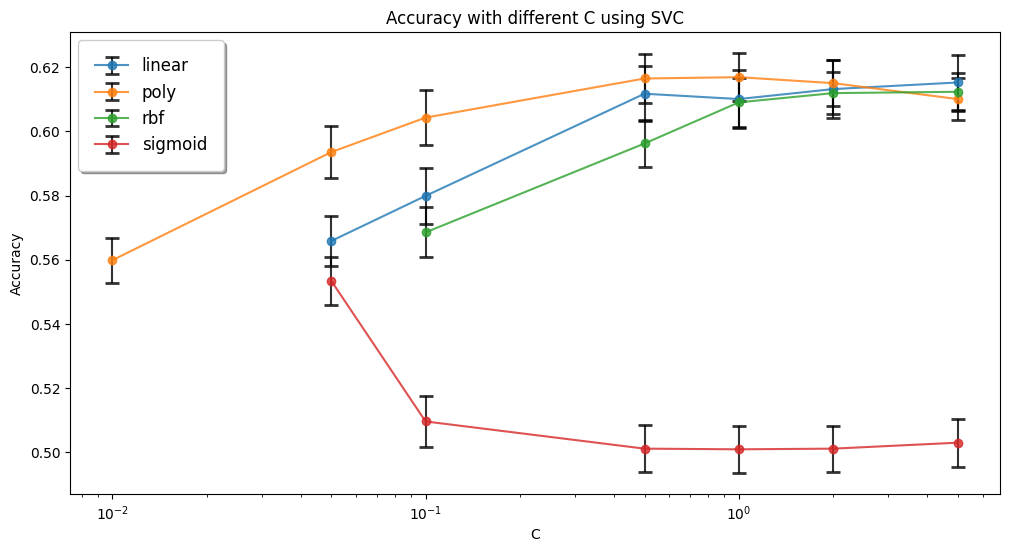

In [47]:
# Plot the accuracy with error bars
plt.figure(figsize=(12, 6))
for i in range(len(kernel_list)):
    acc = accuracy_array[i][accuracy_array[i] != 0]
    filtered_C_list = np.array(C_list)[accuracy_array[i] != 0]  # Use a different variable name
    error = error_array[i][accuracy_array[i] != 0]
    plt.errorbar(filtered_C_list, acc, yerr=error, fmt='o-', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5, label=kernel_list[i])
plt.xscale('log')
plt.title("Accuracy with different C using SVC")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.legend(fancybox=True, loc='best', fontsize=12, shadow=True, borderpad=1)
plt.show()

## Logistic Regression

Finally we analyze the maximum iterations effect.

In [54]:
from sklearn.linear_model import LogisticRegression

C_list = [0.01, 0.05, 0.1, 0.5, 1, 2, 5, 10, 20, 50, 100]
accuracy_list = []
error_list = []

kf = KFold(n_splits=10, shuffle=True, random_state=random_seed)

for C in C_list:

    accuracy_mean = []

    for train_index, test_index in kf.split(dFeat, dClass):

        X_train, X_test = dFeat[train_index], dFeat[test_index]
        y_train, y_test = dClass[train_index], dClass[test_index]

        # Create Classifier
        lr = LogisticRegression(random_state=random_seed, C=C)

        # Fit the model on the training data
        lr.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = lr.predict(X_test)

        # Calculate performance metrics
        pm = Performance_metrics(y_test, y_pred)
        accuracy_mean.append(pm.accuracy())
    
    acc = np.mean(accuracy_mean)
    print("Accuracy with C ", C , " : ", acc)
    accuracy_list.append(acc)
    error_list.append(np.std(accuracy_mean)/np.sqrt(len(accuracy_mean)))

Accuracy with C  0.01  :  0.572888540971545
Accuracy with C  0.05  :  0.599347654980066
Accuracy with C  0.1  :  0.6096842222336294
Accuracy with C  0.5  :  0.6224992727957155
Accuracy with C  1  :  0.6258046301524562
Accuracy with C  2  :  0.6301451841965676
Accuracy with C  5  :  0.63138656468696
Accuracy with C  10  :  0.6307650189073113
Accuracy with C  20  :  0.6309720582447855
Accuracy with C  50  :  0.6303517957668155
Accuracy with C  100  :  0.6301443286621152


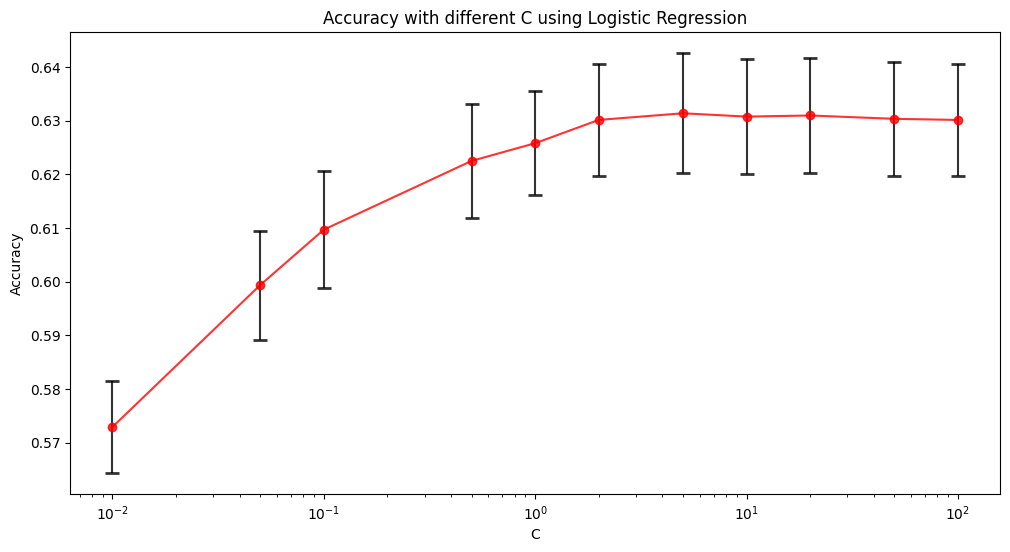

In [56]:
# Plot the accuracy with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(C_list, accuracy_list, yerr=error_list, fmt='o-', color='red', alpha=0.8, capsize=5, capthick=2, lw=1.5, ecolor='black', elinewidth=1.5)
plt.title("Accuracy with different C using Logistic Regression")
plt.xscale('log')
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.show()

# ROC Curve

In [ ]:

models_dict = {
    "RF": RandomForestClassifier(n_estimators=100, random_state=random_seed, criterion='entropy'), # Random Forest
    "DT": DecisionTreeClassifier(random_state=random_seed, criterion='gini', max_depth=8), # Decision Tree
    "KNN": KNeighborsClassifier(n_neighbors=90, n_jobs=-1), # K-Nearest Neighbors
    "GNB": GaussianNB(), # Gaussian Naive Bayes
    "SVC": SVC(random_state=random_seed, kernel='poly', C=1, probability=True), # Support Vector Classifier
    "LR": LogisticRegression(random_state=random_seed, C=5), # Logistic Regression
}

In [60]:
# Now we compute the ROC curve and AUC for the different classifiers
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split


Roc_dict = {
    "RF": [],
    "DT": [],
    "KNN": [],
    "GNB": [],
    "SVC": [],
    "LR": []
}

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dFeat, dClass, test_size=0.2, random_state=random_seed)

# Compute each classification task
for clf_name, clf in models_dict.items():

    print(f"Classifier: {clf_name}")
    # Create a Random Forest Classifier
    model = clf

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate the ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
    mean_auc = auc(fpr, tpr)

    Roc_dict[clf_name].append((fpr, tpr, auc))

Classifier: RF
Classifier: DT
Classifier: KNN
Classifier: GNB
Classifier: SVC
Classifier: LR


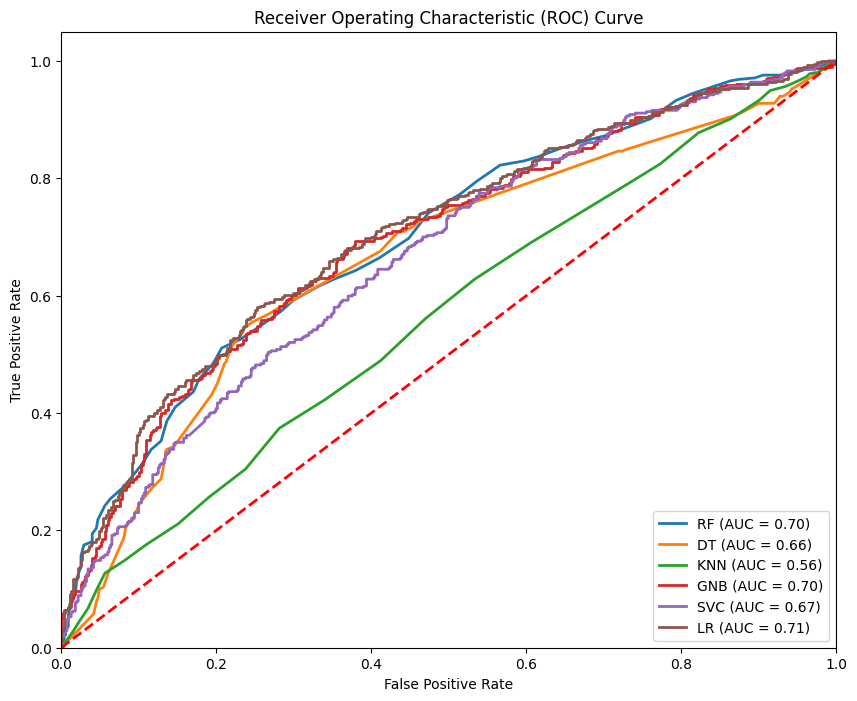

In [61]:
# Plotting the ROC curves for each classifier
plt.figure(figsize=(10, 8))

for clf_name, meas_list in Roc_dict.items():
    mean_fpr = meas_list[0][0]
    mean_tpr = meas_list[0][1]
    mean_auc = auc(mean_fpr, mean_tpr)  # Calculate the AUC value
    plt.plot(mean_fpr, mean_tpr, label=f'{clf_name} (AUC = {mean_auc:.2f})', lw=2)

plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

# Model measure comparison

In this section we compare the measures and the performance metrics and cost for each classifier.

In [85]:
kf = KFold(n_splits=7, shuffle=True, random_state=random_seed)

Performance_metrics_dict = {
    "RF": [],
    "DT": [],
    "KNN": [],
    "GNB": [],
    "SVC": [],
    "LR": []
}

for model_name, model in models_dict.items():

    print(f"Classifier: {model_name}")

    accuracy_list = []
    precision_list = []
    recall_list = []
    f_measure_list = []
    cost_list = []

    for train_index, test_index in kf.split(dFeat, dClass):

        X_train, X_test = dFeat[train_index], dFeat[test_index]
        y_train, y_test = dClass[train_index], dClass[test_index]

        # Fit the model on the training data
        model.fit(X_train, y_train)

        # Make predictions on the test data
        y_pred = model.predict(X_test)

        # Calculate performance metrics
        pm = Performance_metrics(y_test, y_pred)
        accuracy_list.append(pm.accuracy())
        precision_list.append(pm.precision())
        recall_list.append(pm.recall())
        f_measure_list.append(pm.f_measure())
        cost_list.append(pm.cost())

    acc = np.mean(accuracy_list)
    precision = np.mean(precision_list)
    recall = np.mean(recall_list)
    f_measure = np.mean(f_measure_list)
    cost = np.mean(cost_list)

    # Store the performance metrics in the dictionary
    Performance_metrics_dict[model_name].append((acc, precision, recall, f_measure, cost))

# Create a DataFrame to store the performance metrics
performance_df = pd.DataFrame(columns=["Classifier", "Accuracy", "Precision", "Recall", "F-measure", "Cost"])

for model_name, metrics in Performance_metrics_dict.items():
    acc, precision, recall, f_measure, cost = metrics[0]
    performance_df = pd.concat([performance_df, pd.DataFrame([[model_name, acc, precision, recall, f_measure, cost]], columns=["Classifier", "Accuracy", "Precision", "Recall", "F-measure", "Cost"])], ignore_index=True)

performance_df = performance_df.set_index("Classifier")
performance_df = performance_df.sort_values(by="Accuracy", ascending=False)
performance_df

Classifier: RF
Classifier: DT
Classifier: KNN
Classifier: GNB
Classifier: SVC
Classifier: LR


C:\Users\mate1\AppData\Local\Temp\ipykernel_13552\1182530628.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance_df = pd.concat([performance_df, pd.DataFrame([[model_name, acc, precision, recall, f_measure, cost]], columns=["Classifier", "Accuracy", "Precision", "Recall", "F-measure", "Cost"])], ignore_index=True)


,Accuracy,Precision,Recall,F-measure,Cost
Classifier,,,,,
RF,0.636758,0.475445,0.621253,0.537998,607.571429
LR,0.628902,0.377893,0.641765,0.474993,514.714286
DT,0.622907,0.451028,0.602414,0.514211,625.714286
SVC,0.615051,0.367999,0.614596,0.459438,550.571429
GNB,0.614430,0.263553,0.672176,0.377810,424.142857
KNN,0.566467,0.257071,0.528661,0.345409,582.428571


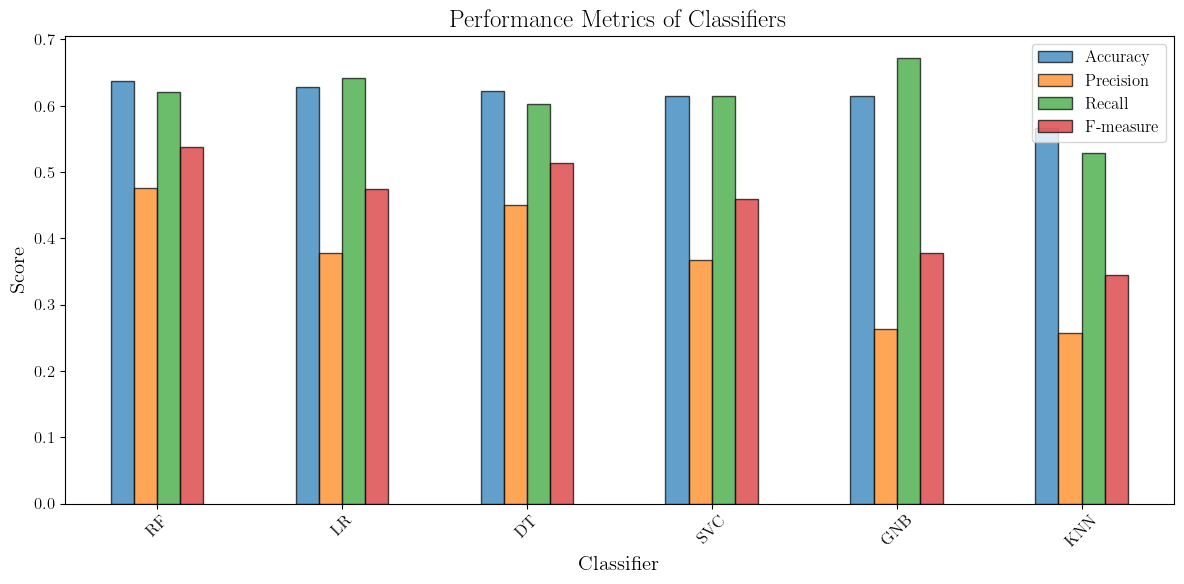

In [107]:
# Plot bar chart of performance metrics
no_cost_df = performance_df.drop(columns=["Cost"])

no_cost_df.plot(kind='bar', figsize=(12, 6), alpha=0.7, edgecolor='black')
plt.title("Performance Metrics of Classifiers")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

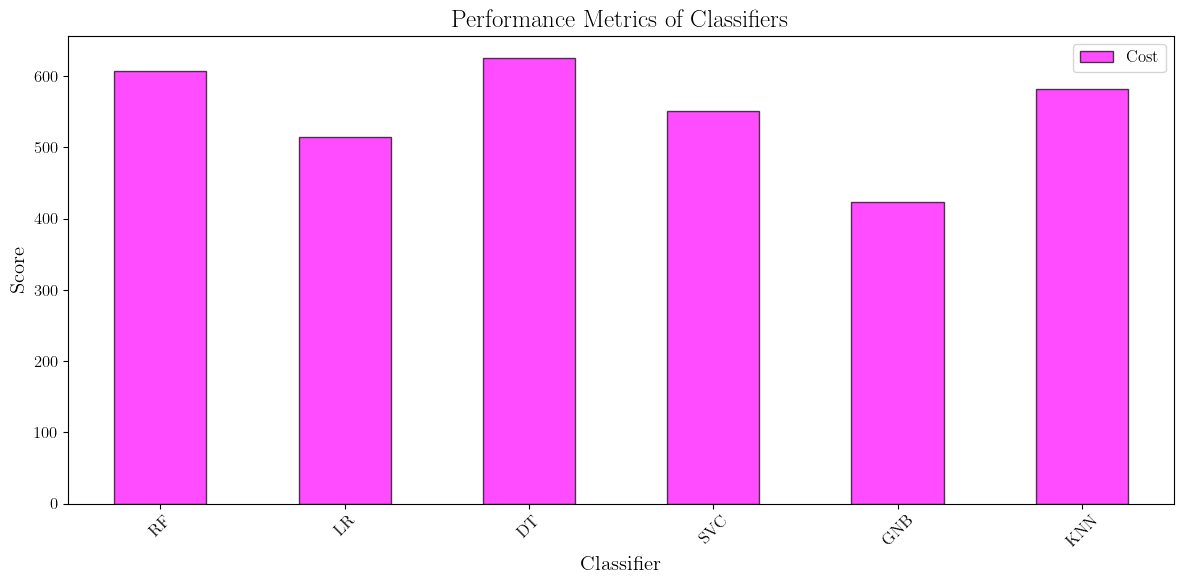

In [106]:
cost_df = performance_df.drop(columns=["Accuracy", "Precision", "Recall", "F-measure"])

cost_df.plot(kind='bar', figsize=(12, 6), alpha=0.7, edgecolor='black', color='magenta')
plt.title("Performance Metrics of Classifiers")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()